In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer

In [2]:
# Reading the data file into a DATAFRAME and checking the shape 
data=pd.read_csv('35.1AmazonMobileDataUncleaned.csv')
print(data.shape)

(71922, 2)


In [3]:
def datapreprocess(sen):
    
    sen = re.sub(r"didn't", "did not", sen)
    sen = re.sub(r"don't", "do not", sen)
    sen = re.sub(r"won't", "will not", sen)
    sen = re.sub(r"can't", "can not", sen)
    sen = re.sub(r"wasn't", "do not", sen)
    sen = re.sub(r"\'ve", " have", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"\'ll", " will", sen)
    sen = re.sub(r"\'re", " are", sen)
    sen = re.sub(r"\'s", " is", sen)
    sen = re.sub(r"\'d", " would", sen)
    sen = re.sub(r"\'t", " not", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"n\'t", " not", sen)
    
    p = set(string.punctuation) # p take all the punctuations, punctuations displayed below
    sen=sen.lower() # convert text to lower case
    words=sen.split() # split the text into words
    ctext=[]
    for i in range(10): #adding numbers from 0 - 9 to p 
        p.add(str(i))
    for i in words:
        t=''.join([x for x in i.encode("ascii","ignore").decode("ascii") if x not in p]) # ignoring non ascii charecters and numbers
        ctext.append(t)
    return " ".join([i for i in ctext]) # joining the cleaned words to text
    
    

stop=set(stopwords.words('english'))
print(stop)
stop.remove('no')
stop.remove('not')
stop.remove('nor')

preprocessed_essays = []
for sentance in data['uncleanedreview'].values:
    try:
        ctxt=datapreprocess(str(sentance))
        if len(ctxt)==0: raise()
        ctxt = ' '.join(e for e in ctxt.split() if e not in stop)
        preprocessed_essays.append(ctxt.lower().strip())
    except:
        preprocessed_essays.append("NAN")  
data['cleanedtext'] = preprocessed_essays
data.drop(data[data["cleanedtext"]=="NAN"].index,axis = 0,inplace = True) # deleting rows that have no text 
data=data.reset_index(drop='true') # after deleting rows index should be reset
data['decision']= data['decision'].replace('positive',1)
data['decision']= data['decision'].replace('negative',0)


s = SnowballStemmer("english")
p=[]
for i in data['cleanedtext'].values:
    k=[]
    for word in i.split():
        k.append(s.stem(word))
    l=' '.join(k)
    p.append(l)

data['j']=p

data.to_csv (r'AmazonMobileDataCleaned.csv')

{'when', "you'll", 'by', 'yourselves', 'the', 'm', 'most', 'some', 'haven', 'that', 'own', 'herself', "aren't", 'what', 'will', 'yourself', 'than', 'our', 'this', 'which', "hadn't", 'ourselves', 'it', 'his', 'through', 'wouldn', 'you', 'ain', 'no', 'just', 'won', 'll', 'being', "hasn't", 'mightn', 'why', "she's", 'an', 'until', 'are', 'after', "needn't", 'itself', 're', 'myself', 'from', 'who', 'same', "wouldn't", 'shan', 'before', 'further', 'with', "mustn't", 'her', 'its', 'them', 'did', 'any', "you're", "won't", 'isn', 'over', 'she', 'has', 'were', 'between', 'there', 'into', "it's", 'd', 'they', 't', 'up', 'because', 'doesn', 'above', 'himself', "you've", 'on', 'only', 'here', 'been', 'have', 'y', "you'd", 'more', 'couldn', "didn't", 'yours', 'both', 'then', 'all', 'each', 'such', 'once', 'is', 's', "don't", 'shouldn', 'don', 'now', 'under', 'a', "mightn't", 'for', 'your', 'be', 'at', 'again', 'theirs', 'of', 'i', 'and', 'very', 'down', 'nor', 'hadn', "shan't", 'their', 'themselves

In [4]:
data=pd.read_csv('AmazonMobileDataCleaned.csv',nrows = 5000)
print(data.shape)
label = data['decision'].values
feedback = data.drop(['decision'], axis=1)
print(label.shape)
print(feedback.shape)
print("------------------------------")

from sklearn.model_selection import train_test_split
inputtrain, inputtest, outputtrain, outputtest = train_test_split(feedback, label, test_size=0.20, stratify=label)
print(inputtrain.shape)
print(inputtest.shape)
print(outputtrain.shape)
print(outputtest.shape)

(5000, 5)
(5000,)
(5000, 4)
------------------------------
(4000, 4)
(1000, 4)
(4000,)
(1000,)


In [5]:
# convert into Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(min_df=10,ngram_range=(1,4))
vec.fit(inputtrain['j'].values) # fit has to happen only on train data


train_cleanedtext = vec.transform(inputtrain['j'].values)
test_cleanedtext= vec.transform(inputtest['j'].values)

print("After vectorizations")
print(train_cleanedtext.shape)
print(test_cleanedtext.shape)
print(outputtrain.shape)
print(outputtest.shape)
print("...............................")

After vectorizations
(4000, 2823)
(1000, 2823)
(4000,)
(1000,)
...............................


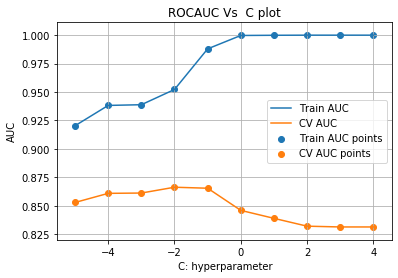

{'C': 0.01}
0.8662603041913387
best C log value
-2.0


In [7]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt


neigh = SVC(kernel = 'linear')

C=np.array([0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]) # Different C values
tuned_parameters = {'C' : C} 


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(train_cleanedtext, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_C']

alpha1=[]
for i in range(0,len(k),1):
   l=math.log10(k[i])
   alpha1.append(l)
alpha1.sort()
plt.plot(alpha1, train_auc, label='Train AUC')

plt.plot(alpha1, cv_auc, label='CV AUC')

plt.scatter(alpha1, train_auc, label='Train AUC points')
plt.scatter(alpha1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel(" C: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs  C plot")
plt.grid()
plt.show()


print(clf.best_params_)
print(clf.best_score_)
print("best C log value")
a=math.log10(clf.best_params_.get('C'))
print(a)

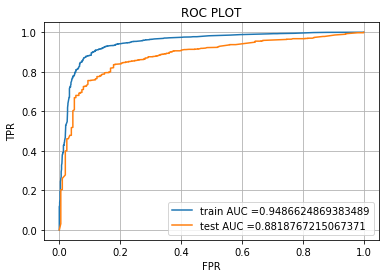

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.8016629900537946 for threshold 0.752
Train confusion matrix


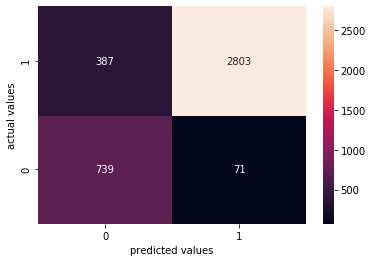

Test confusion matrix


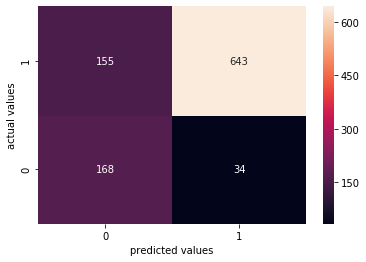

In [8]:

from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV

neigh = SVC(kernel = 'linear',C=0.01)
neigh.fit(train_cleanedtext, outputtrain)

clfcalibrated = CalibratedClassifierCV(neigh, cv=3, method='isotonic')
clfcalibrated.fit(train_cleanedtext, outputtrain)

y_train_pred = clfcalibrated.predict_proba(train_cleanedtext)[:,1]    
y_test_pred = clfcalibrated.predict_proba(test_cleanedtext)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax=sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()